# Compare the lgw problem with vs without base state evolution for the *unmodified* equations

### Preamble / imports

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import yt
##yt.mylog.setLevel()
yt.utilities.logger.disable_stream_logging()

### Data paths

In [7]:
# put the relative or absolute directory of the problem output here
dataDir1 = '../oldruns/thu27/evolveTrue/'
baseName1 = 'plt'
dsPath1 = dataDir1 + baseName1
tsPath1 = dsPath1 + '???????/'
ds0Path1 = dsPath1 + '0000000/'

dataDir2 = '../oldruns/thu27/evolveFalse/'
baseName2 = 'plt'
dsPath2 = dataDir2 + baseName2
tsPath2 = dsPath2 + '???????/'
ds0Path2 = dsPath2 + '0000000/'

A sensible default might be dataDir/post

In [54]:
outDir1 = dataDir1+"post/"
outDir2 = dataDir2+"post/"

Create the output directory if it doesn't exist

In [55]:
%%bash -s "$outDir1" 
mkdir -p $1

In [56]:
%%bash -s "$outDir2" 
mkdir -p $1

#### Some useful functions

In [8]:
# gets an ordered list of the directories containing the plotfiles without using yt's ts object.
# useful for raw base state data and other things
import re
import os
def getPltFiles(dataDir):
    dirs = [f.name for f in os.scandir(dataDir) if f.is_dir() ]    
    matches = [dataDir + string for string in dirs if re.match(r"plt[0-9]{4,7}$", string)]
    return sorted(matches)
    
pltFiles1 = getPltFiles(dataDir1)
pltFiles2 = getPltFiles(dataDir2)

In [4]:
# This commented version uses yt and is SLOW AF
# def basesubTimeDistance(tsPath, var, normalise = True):
#     ts = yt.load(tsPath)

#     ds0= ts[0]
#     ray = ds0.ortho_ray(1, (0,0))
#     y = np.array(ray['y'])
#     linedata0 = np.array(ray[var])

#     dataArr = np.zeros([y.size,len(ts)], dtype='double' )
#     time = []
#     for i, ds in enumerate(ts):
#         ray = ds.ortho_ray(1, (0,0))
#         linedata = np.array(ray[var])
#         linedata = linedata - linedata0
#         if normalise:
#             linedata = linedata / linedata0
#         dataArr[:,i] = linedata
#         time.append(float(ds.current_time))


#     plt.contourf(time, y, dataArr, cmap=plt.cm.RdBu_r)
#     plt.xlabel('time')
#     plt.ylabel('y') 
#     plt.title('var = {}'.format(var))
#     plt.colorbar()
    
# basesubTimeDistance(tsPath1, "w0y", normalise=False)

In [29]:
# This uses raw data from the plotfiles
def basesubTimeDistance(pltFiles, var, removeT0 = True):
    for i, mydir in enumerate(pltFiles):
        BaseCC_0 = mydir+'/BaseCC_0'
        BaseFC_0 = mydir+'/BaseFC_0'
        r_cc, rho0, rhoh0, p0, gamma1bar = np.loadtxt(BaseCC_0, skiprows=1, unpack=True)
        r_edge, w0 = np.loadtxt(BaseFC_0, skiprows=1, unpack=True)

        dataSwitch = {
            'rho0': rho0,
            'rhoh0': rhoh0,
            'p0': p0,
            'w0': w0
        }
        
        if i==0 :
            center_face_switch = {
                'rho0': len(r_cc),
                'rhoh0': len(r_cc),
                'p0': len(r_cc),
                'w0': len(r_edge)
            }
            dataArr = np.zeros([center_face_switch.get(var,"err"),len(pltFiles)], dtype='double')
            d0 = dataSwitch.get(var,"error")

        
        dataArr[:,i] = dataSwitch.get(var,"error")

        if removeT0:
            dataArr[:,i] = dataArr[:,i] - d0

    plt.contourf(dataArr, cmap=plt.cm.RdBu_r)
    plt.xlabel('pltnumber')
    plt.ylabel('cell ') 
    plt.title('var = {}'.format(var))
    plt.colorbar()        

### First, confirm that there is no background evolution in the evolveFalse run

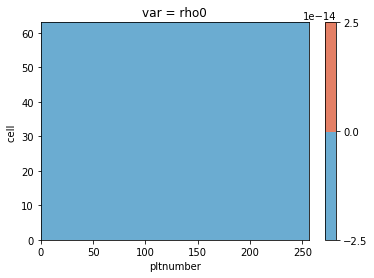

In [31]:
basesubTimeDistance(pltFiles2,'rho0', removeT0 = True)

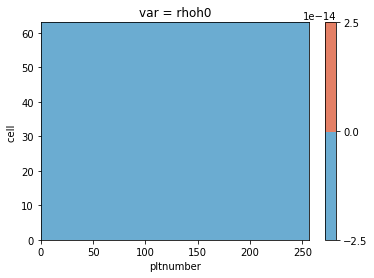

In [34]:
basesubTimeDistance(pltFiles2,'rhoh0', removeT0 = True)

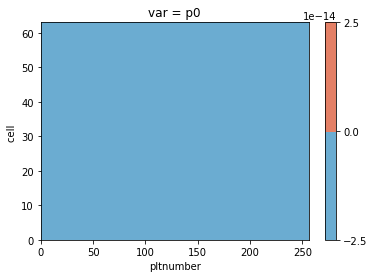

In [32]:
basesubTimeDistance(pltFiles2,'p0', removeT0 = True)

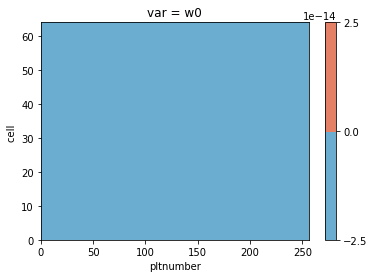

In [33]:
basesubTimeDistance(pltFiles2,'w0', removeT0 = False)

### And also, confirm that there is indeed background evolution in the evolveTrue run (incase dirs mixed up, etc)

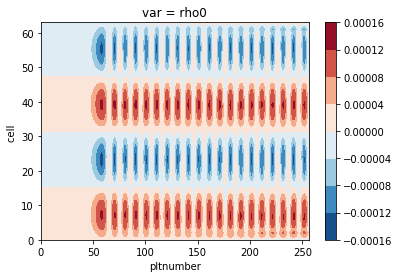

In [35]:
basesubTimeDistance(pltFiles1,'rho0', removeT0 = True)

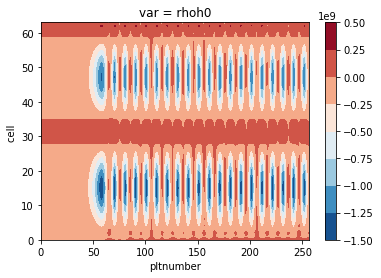

In [36]:
basesubTimeDistance(pltFiles1,'rhoh0', removeT0 = True)

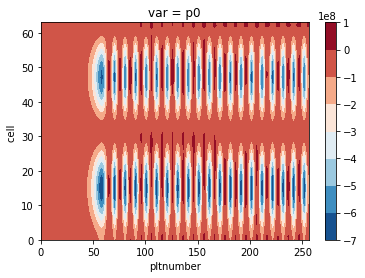

In [37]:
basesubTimeDistance(pltFiles1,'p0', removeT0 = True)

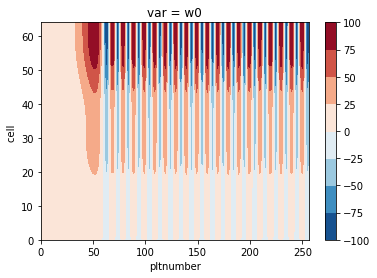

In [39]:
basesubTimeDistance(pltFiles1,'w0', removeT0 = False)

## Periods

In [44]:
def quickProbePlot(tsPath,kv_int=2,kh_int=4, cx = 1e9/2, cy = 1e9/4, var='rhopert'):
    
    ts = yt.load(tsPath) # I'd love a way to make this quiet
    pointdata  = []
    time = []
    for ds in ts:
        pointdata.append(ds.point([cx, cy, 0.])[var].value[0])
        time.append(float(ds.current_time))
    
    
    gamma = 5./3. 
    g = 3e4
    H = 1e9
    N2 = (gamma-1.)/gamma * g / H
    kv = kv_int * np.pi  / H
    kh = kh_int * np.pi / H
    k2 = kv**2 + kh**2 
    w2 = N2 * kh**2 / (k2 )
    w = np.sqrt(w2)
    
    print('kh_int=',kh_int)
    print('N=',np.sqrt(N2))
    print('w(expected)=',w)
    print('P(expected)=',2.0*np.pi/w)


    smoothTime = np.linspace(0,2e4,1e3)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(time, pointdata, '+r', time, pointdata, 'r',
        smoothTime, pointdata[0] * np.cos(-w * smoothTime), 'b')

    plt.show()
    
    return time, pointdata

Visually comparing the signal at a given probe point looks pretty comparible 

kh_int= 4
N= 0.0034641016151377548
w(expected)= 0.0030983866769659332
P(expected)= 2027.8893379868061


/data/njt132/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


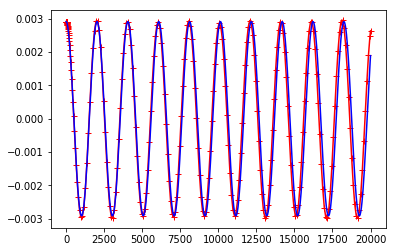

In [46]:
time1, pointdata1 = quickProbePlot(tsPath1)

kh_int= 4
N= 0.0034641016151377548
w(expected)= 0.0030983866769659332
P(expected)= 2027.8893379868061


/data/njt132/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


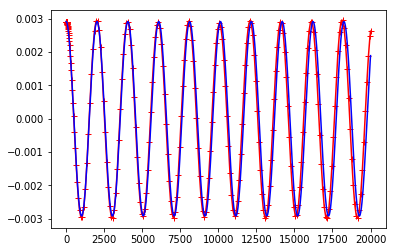

In [47]:
time2, pointdata2 = quickProbePlot(tsPath2)

it looks like the simulations run with exactly the same choices of dt

In [66]:
max(np.array(time1) - np.array(time2))

0.0

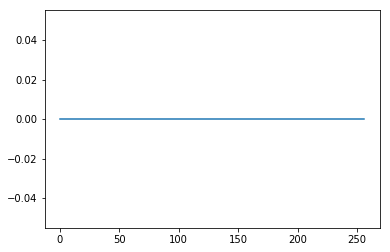

In [62]:
plt.plot(np.array(time1) - np.array(time2)) ## have to change to numpy arrays

There is some difference in the value of the data at the probe point, however it is something like 1/100 difference when comparing it to the maximum

0.0029759938055438084 0.00297156882902333 1.5177899190532695e-05


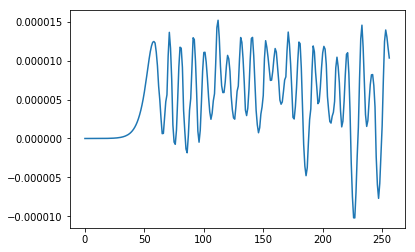

In [78]:
diff = np.array(pointdata1) - np.array(pointdata2)
plt.plot(np.array(pointdata1) - np.array(pointdata2)) ## have to change to numpy arrays
print(max(abs(np.array(pointdata1))), max(abs(np.array(pointdata2))), max(abs(diff)))

## Want to look at the dynamic evolution of the 2D data, but in a fair comparison

#### rhopert

have already seen it will have a small difference, since the probe values aren't exactly the same

In [156]:
# # This is the normal yt way to do a plot - but you can't access the raw data to manipulate it!!!
# ds = yt.load(ds0Path1)
# var = "rhopert"
# plot = yt.SlicePlot(ds, "z", var)
# plot.set_log(var, False);
# plot.set_cmap(field=var, cmap='RdBu')
# plot.annotate_title("t = {}".format(ds.current_time) )

In [155]:
# # This a way you can get at the raw data!!!
# ds = yt.load(ds0Path1)
# all_data_level_0 = ds.covering_grid(level=0, left_edge=[0,0.0,0.0],
#                                       dims=[64, 64, 1])
# pltdata=all_data_level_0['rhopert']
# # plt.contourf(pltdata[:,:,0].transpose(), cmap=plt.cm.RdBu_r)
# plt.imshow(pltdata[:,:,0].transpose(), origin='lower', cmap=plt.cm.RdBu)
# plt.xlabel('time')
# plt.ylabel('y') 
# plt.title('var = {}'.format(var))
# plt.colorbar()

## this one subtracts off rho0(t=0) from rho(t) in the case of the evolving background run.

This (maybe) should be equivalent to rhopert in the non-background evolging case

In [76]:
def rhoPertAlt(tsPath,show=False,save=False,outDir='./'):
    ts = yt.load(tsPath)
    ds0= ts[0]
    all_data_level_0 = ds0.covering_grid(level=0, left_edge=[0,0.0,0.0], dims=[64, 64, 1])
    rho0T0 = all_data_level_0['rho0']
    rho0T0 = rho0T0[:,:,0].transpose()    
    dataArr = np.zeros([rho0T0.shape[0],rho0T0.shape[1],len(ts)],dtype="double")
    
    filePath = outDir + '/rhoPertAlt/'
    if save:
        # make a subdirectory for the particular variable name
        args= " -p " + outDir + '/rhoPertAlt/'
        %mkdir $args # the magick will only work in ipython / jupyter - do something smarter in normal scripts

        # remove any existing png in that dir
        args= " " + outDir + '/rhoPertAlt/' + '/*.png'
        %rm $args

    for i, ds in enumerate(ts):
        all_data_level_0 = ds.covering_grid(level=0, left_edge=[0,0.0,0.0], dims=[64, 64, 1])
        rho = all_data_level_0['rho']
        rho = rho[:,:,0].transpose()
        
        diff = rho-rho0T0

        if show:
            plt.imshow(diff, origin='lower', cmap=plt.cm.RdBu)
            plt.xlabel('x(index)')
            plt.ylabel('y(index)') 
            plt.title('rhofull (t={})- rho0(t=0)'.format(ds.current_time.value ))
            plt.colorbar()
            plt.show()

        if save:
            fileName = "{}{:04}.png".format(filePath,i)
            plt.imshow(diff, origin='lower', cmap=plt.cm.RdBu)
            plt.xlabel('x(index)')
            plt.ylabel('y(index)') 
            plt.title('rhofull (t={})- rho0(t=0)'.format(ds.current_time.value ))
            plt.colorbar()
            plt.savefig(fname=fileName)
            #print('saved {}'.format(fileName)) # can take up too much vertical space if a big dataset
            plt.clf() 
    
        dataArr[:,:,i] = diff

    return dataArr

In [77]:
def rhoPert(tsPath,show=False, save=False,outDir='./'):
    
    ts = yt.load(tsPath)
    # in this one, the ds0 stuff isnt really used except to set the shape of dataArr
    ds0= ts[0]
    all_data_level_0 = ds0.covering_grid(level=0, left_edge=[0,0.0,0.0], dims=[64, 64, 1])
    rho0T0 = all_data_level_0['rho0']
    rho0T0 = rho0T0[:,:,0].transpose()
    
    dataArr = np.zeros([rho0T0.shape[0],rho0T0.shape[1],len(ts)],dtype="double")
    
    filePath = outDir + '/rhopert/'
    if save:
        # make a subdirectory for the particular variable name
        args= " -p " + outDir + '/rhopert/'
        %mkdir $args # the magick will only work in ipython / jupyter - do something smarter in normal scripts

        # remove any existing png in that dir
        args= " " + outDir + '/rhopert/' + '/*.png'
        %rm $args
    
    for i, ds in enumerate(ts):
        all_data_level_0 = ds.covering_grid(level=0, left_edge=[0,0.0,0.0], dims=[64, 64, 1])
        rho = all_data_level_0['rhopert']
        rho = rho[:,:,0].transpose()
        
        diff = rho #  not really a diff anymore, havent changed varname tho

        if show:
            plt.imshow(diff, origin='lower', cmap=plt.cm.RdBu)
            plt.xlabel('x(index)')
            plt.ylabel('y(index)') 
            plt.title('rhopert (t={})'.format(ds.current_time.value ))
            plt.colorbar()
            plt.show()
            
        if save:
            fileName = "{}{:04}.png".format(filePath,i)
            plt.imshow(diff, origin='lower', cmap=plt.cm.RdBu)
            plt.xlabel('x(index)')
            plt.ylabel('y(index)') 
            plt.title('rhofull (t={})- rho0(t=0)'.format(ds.current_time.value ))
            plt.colorbar()
            plt.savefig(fname=fileName)
            #print('saved {}'.format(fileName))
            plt.clf() # fuck you matplotlib

    
        dataArr[:,:,i] = diff

    return dataArr

In [71]:
evolvingData = rhoPertAlt(tsPath1, show=False, save=True, outDir=outDir1)

<Figure size 432x288 with 0 Axes>

In [ ]:
noEvoData = rhoPert(tsPath2, show=False, save=True, outDir=outDir2)

In [45]:
difference = evolvingData - noEvoData 

In [53]:
print( np.max(np.abs(difference)), np.min(np.abs(difference)))

3.428283934009402e-05 0.0
